In [1]:
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import fiona
import numpy as np
import shapefile as shp
import pandas as pd
import os
import folium
from geopy.geocoders import Nominatim
from geopy import distance
import seaborn as sns
from shapely.geometry import Point, Polygon
from datetime import datetime

shp_file_name = "NSW_LOC_POLYGON_shp/NSW_LOC_POLYGON_shp.shp"
zip_file_name = "nsw_locality_polygon_shp.zip"
web_file_path = (
    "https://data.gov.au/data/dataset/"
    "91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
    "5e295412-357c-49a2-98d5-6caf099c2339/download/"
    "nsw_locality_polygon_shp.zip"
)

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (11, 7)

In [3]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

In [4]:
# Get the data loaded. This is a bit complicated because it's online as a zip file.
# If we don't have it right now, we need to get it and unzip it.
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)
    else:
        import requests
        print("loading from the internet")
        page = requests.get(web_file_path)
        with open(zip_file_name, 'wb') as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


In [5]:
os.listdir(".")

['.git',
 '.gitattributes',
 '.gitignore',
 '.ipynb_checkpoints',
 'addresses.csv',
 'all_burbs.png',
 'basic_pandas.ipynb',
 'BurntArea_2019-2020_shp',
 'BurntArea_2019-2020_shp.zip',
 'bushfire_data',
 'Bushfire_Impact_Water_Data.ipynb',
 'Humor-Sans.ttf',
 'Info for project',
 'Lake Conjola Data Set.ipynb',
 'lake_addresses_data',
 'lake_data',
 'Lake_Quality_Risk.csv',
 'LC_Health_Risk_shp',
 'LC_Health_Risk_shp.zip',
 'LC_nutrient_levels.csv',
 'LICENSE',
 'maps',
 'maps.ipynb',
 'ML_Health_Risk_2_shp',
 'ML_Health_Risk_2_shp.zip',
 'nsw_locality_polygon_shp.zip',
 'NSW_LOC_POLYGON_shp',
 'nutrient loading',
 'photos',
 'README.md',
 'TL_Shape_1_shp',
 'TL_Shape_1_shp.zip',
 'tricks.ipynb',
 'tricks.py',
 'TR_Shape_2_shp',
 'TR_Shape_2_shp.zip']

In [6]:
folder = "lake_data"
all_dataframes = []
for file_name in os.listdir(folder):
    print(file_name)
    df = pd.read_csv(os.path.join(folder, file_name), parse_dates=[0])
    df.columns = [
        "dateTime",
        "estuaryName",
        "siteID",
        "loggerID",
        "sampleDepth",
        "conductivity",
        "temp",
        "dissolvedOxygen",
    ]
    df["source_file"] = file_name
    all_dataframes.append(df)

    all_lakes_df = pd.concat(all_dataframes)

Conjola_Lake_Bushfire_Water_Quality_Data.csv
Meroo_Lake_Bushfire_Water_Quality_Data.csv
Turmeil_Lake_Bushfire_Water_Quality.csv
Tuross_River_Bushfire_Water_Quality_Data.csv


2020 BUSHFIRES IMPACT ON WATER QUALITY 

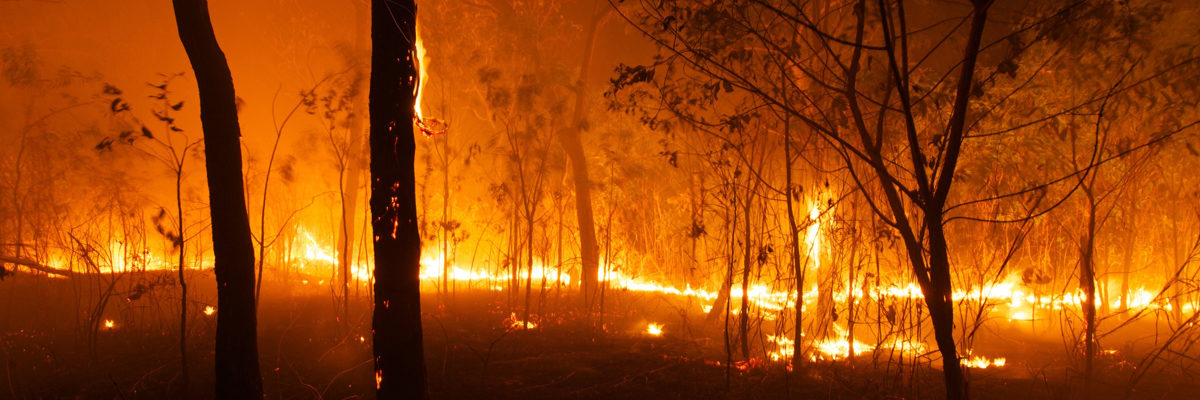

By Gabriella Sasvary (z5364146), GITHUB: gsasvary

The dataset I chose to explore for this project is the 2020 bushfires' impact on water quality. I decided to compare this dataset with three others to gain more information. 

The datasets are on three lakes and one river, Lake Conjola, Lake Meroo, Lake Termeil and Tuross River. I found these datasets on the sharing and enabling environmental data NSW website and they all have over 2500 rows and 9 columns. They were created during the 2020 bushfires to measure the water quality response in each lake during this period of time. The datasets include dates and times of when the data was sampled, the name and site ID of each lake, the samples’ depth, conductivity, temperature and dissolved oxygen levels. 

In [7]:
all_dataframes[0]

,dateTime,estuaryName,siteID,loggerID,sampleDepth,conductivity,temp,dissolvedOxygen,source_file
0,2020-01-20 12:30:00,Lake Conjola,CON1,CON1-Surface,0.5,35444.2,24.95,7.23,Conjola_Lake_Bushfire_Water_Quality_Data.csv
1,2020-01-20 12:45:00,Lake Conjola,CON1,CON1-Surface,0.5,34664.3,25.01,7.64,Conjola_Lake_Bushfire_Water_Quality_Data.csv
2,2020-01-20 13:00:00,Lake Conjola,CON1,CON1-Surface,0.5,34318.8,25.03,7.66,Conjola_Lake_Bushfire_Water_Quality_Data.csv
3,2020-01-20 13:15:00,Lake Conjola,CON1,CON1-Surface,0.5,34164.1,25.06,7.66,Conjola_Lake_Bushfire_Water_Quality_Data.csv
4,2020-01-20 13:30:00,Lake Conjola,CON1,CON1-Surface,0.5,34044.5,25.04,7.67,Conjola_Lake_Bushfire_Water_Quality_Data.csv
...,...,...,...,...,...,...,...,...,...
2682,2020-02-17 11:00:00,Lake Conjola,CON1,CON1-Surface,0.5,529.2,24.76,4.08,Conjola_Lake_Bushfire_Water_Quality_Data.csv
2683,2020-02-17 11:15:00,Lake Conjola,CON1,CON1-Surface,0.5,528.3,24.75,3.86,Conjola_Lake_Bushfire_Water_Quality_Data.csv
2684,2020-02-17 11:30:00,Lake Conjola,CON1,CON1-Surface,0.5,527.9,24.74,4.03,Conjola_Lake_Bushfire_Water_Quality_Data.csv
2685,2020-02-17 11:45:00,Lake Conjola,CON1,CON1-Surface,0.5,526.9,24.76,4.14,Conjola_Lake_Bushfire_Water_Quality_Data.csv


In [8]:
def all_lakes():
    for name, df in all_lakes_df.groupby("estuaryName"):
        print(name, df.shape)
all_lakes_df = pd.concat(all_dataframes)

In [9]:
all_lakes()
all_lakes_df.sample(4)

Lake Conjola (2687, 9)
Meroo Lake (2581, 9)
Termeil Lake (2591, 9)
Tuross River (2643, 9)


,dateTime,estuaryName,siteID,loggerID,sampleDepth,conductivity,temp,dissolvedOxygen,source_file
764,2020-01-29 18:00:00,Tuross River,TUR1,TUR1-Surface,0.5,38719.1,27.77,5.06,Tuross_River_Bushfire_Water_Quality_Data.csv
205,2020-01-23 20:15:00,Meroo Lake,MER1,MER1-Surface,0.5,NaN,26.40,6.88,Meroo_Lake_Bushfire_Water_Quality_Data.csv
1233,2020-02-02 08:45:00,Lake Conjola,CON1,CON1-Surface,0.5,22624.3,28.83,7.72,Conjola_Lake_Bushfire_Water_Quality_Data.csv
530,2020-01-26 01:00:00,Lake Conjola,CON1,CON1-Surface,0.5,33658.1,26.36,8.33,Conjola_Lake_Bushfire_Water_Quality_Data.csv


# How do these bushfires affect local water bodies? 

This was the main question I wanted to focus on. I never really considered whether bushfires affected nearby lakes/rivers until researching into this topic. 

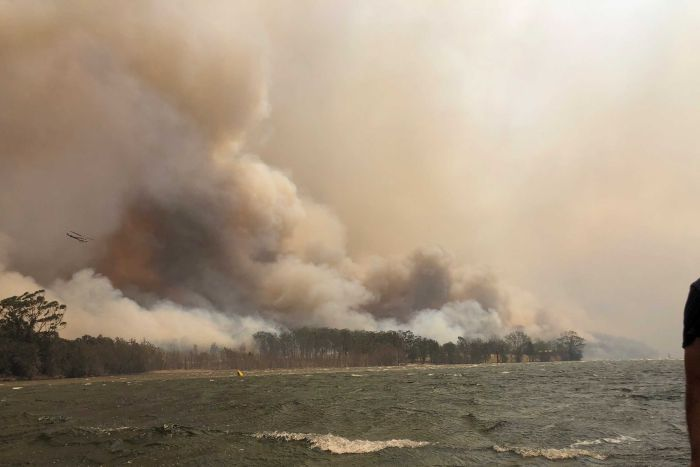

In [10]:
type(df.dateTime[0])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:
df1 = pd.read_csv("lake_addresses_data/lake_addresses.csv")
df = df1.loc[:, ("Name", "City", "State", "Zip", "Longitude", "Latitude", "Type")]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       4 non-null      object 
 1   City       4 non-null      object 
 2   State      4 non-null      object 
 3   Zip        4 non-null      int64  
 4   Longitude  4 non-null      float64
 5   Latitude   4 non-null      float64
 6   Type       4 non-null      object 
dtypes: float64(2), int64(1), object(4)
memory usage: 352.0+ bytes


I began to research whereabouts these lakes were located in order to see if the areas surrounding the lakes were impacted severely by the 2020 bushfires. Lake Conjola, Meroo and Termeil are all located in Shoalhaven City Council, NSW and Tuross River is part of the Eurobodalla Shire Council, NSW.

LOCATIONS OF LAKES:

In [12]:
geometry = gpd.points_from_xy(df.Longitude, df.Latitude)
geo_df = gpd.GeoDataFrame(df[["Name", "City", "State", "Zip", "Longitude", "Latitude", "Type"]], geometry=geometry)

geo_df.head()

,Name,City,State,Zip,Longitude,Latitude,Type,geometry
0,Lake Conjola,Shoalhaven City Council,NSW,2539,-35.269800,150.489122,Lake,POINT (-35.270 150.489)
1,Lake Meroo,Shoalhaven City Council,NSW,2539,-35.483963,150.385142,Lake,POINT (-35.484 150.385)
2,Lake Termeil,Shoalhaven City Council,NSW,2539,-35.481667,150.334444,Lake,POINT (-35.482 150.334)
3,Tuross River,Eurobodalla Shire Council,NSW,2537,-36.054832,150.099219,Lake,POINT (-36.055 150.099)


In [13]:
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
location = geolocator.geocode('Lake Conjola')
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
location = geolocator.geocode('Lake Termeil')
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
location = geolocator.geocode('Meroo Lake')
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
location = geolocator.geocode('Tuross Lake')

I created a base map using folium to plot out all the locations of the lakes/river. I then managed to achieve some close-up maps of each lake/river by importing some shapefiles.

In [14]:
 def location_lakes():
    m = folium.Map(location=(-35.2698003, 150.4891222), zoom_start=8)
    m   
    df['full_address'] = df.Name + "," + df.City + "," + df.State
    df['gcode'] = df.full_address.apply(geolocator.geocode)
    df['lat'] = [g.latitude for g in df.gcode]
    df['long'] = [g.longitude for g in df.gcode]
    for index, row in df.iterrows():
        folium.Marker(location=(row['lat'],row['long'])).add_to(m)
    display(m)
        

In [15]:
location_lakes() 

In [16]:
shp_file_name = "LC_Health_Risk_shp/CONJOLA_LAKE_117_HR.shp"
zip_file_name = "LC_Health_Risk_shp.zip"
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


In [17]:
health_risk = gpd.GeoDataFrame.from_file(shp_file_name)
health_risk.set_crs(epsg=8021, inplace=True, allow_override=True) 
health_risk.sample(1)

,OBJECTID,ZONEID,CATCHMENT,NthSth,LIKELIHOOD,CONSEQUENC,RISK,Shape_Leng,Shape_Le_1,Shape_Area,geometry
42,5697,CONJOLA LAKE 97,CONJOLA LAKE,117.0,4.0,4.0,16.0,12422.280934,0.125841,0.000361,"POLYGON ((150.45875 -35.25505, 150.45848 -35.2..."


In [18]:
def map_1():
    health_risk.geometry.plot(color='lightblue', alpha=0.6, edgecolor='black')
    plt.title("Map of Lake Conjola", fontsize=15)

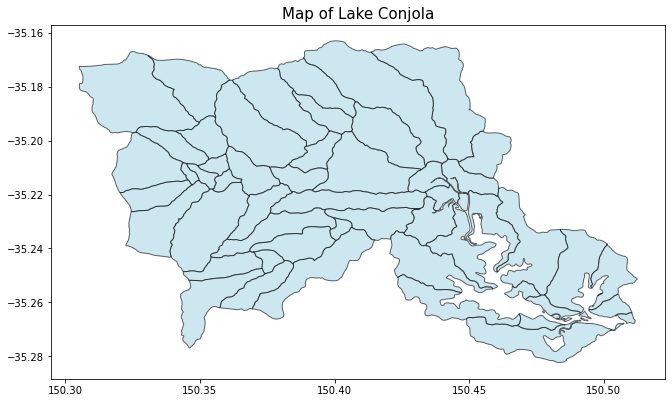

In [19]:
map_1()

In [20]:
shp_file_name = "ML_Health_Risk_2_shp/MEROO_LAKE_125_HR.shp"
zip_file_name = "ML_Health_Risk_2_shp.zip"
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


In [21]:
Health_Risk_2 = gpd.GeoDataFrame.from_file(shp_file_name)
Health_Risk_2.set_crs(epsg=8021, inplace=True, allow_override=True) 
Health_Risk_2.sample(1)

,OBJECTID,ZONEID,CATCHMENT,NthSth,LIKELIHOOD,CONSEQUENC,RISK,Shape_Leng,Shape_Le_1,Shape_Area,geometry
22,6147,MEROO LAKE 73,MEROO LAKE,125.0,1.0,1.0,1.0,965.711898,0.009949,0.000003,"POLYGON ((150.36774 -35.48588, 150.36779 -35.4..."


In [22]:
def map_2():
    Health_Risk_2.geometry.plot(color='lightblue', alpha=0.6, edgecolor='black')
    plt.title("Map of Meroo Lake", fontsize=15)

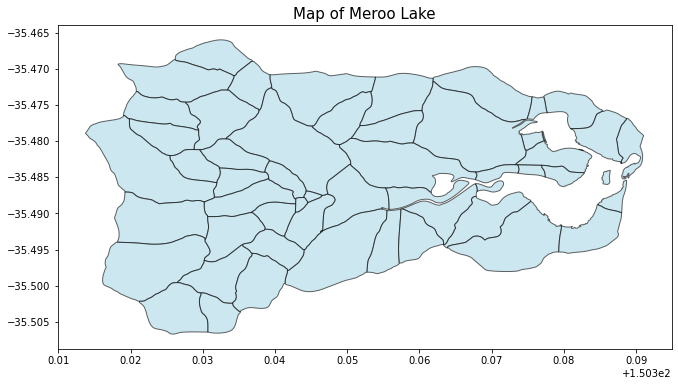

In [23]:
map_2()

In [24]:
shp_file_name = "TL_Shape_1_shp/TERMEIL_LAKE_124_HR.shp"
zip_file_name = "TL_Shape_1_shp.zip"
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


In [25]:
Shape_1 = gpd.GeoDataFrame.from_file(shp_file_name)
Shape_1.set_crs(epsg=8021, inplace=True, allow_override=True) 
Shape_1.sample(1)

,OBJECTID,ZONEID,CATCHMENT,NthSth,LIKELIHOOD,CONSEQUENC,RISK,Shape_Leng,Shape_Le_1,Shape_Area,geometry
9,6787,TERMEIL LAKE 201,TERMEIL LAKE,124.0,1.0,1.0,1.0,1432.506082,0.014062,0.000005,"POLYGON ((150.37800 -35.45959, 150.37813 -35.4..."


In [26]:
def map_3():
    Shape_1.geometry.plot(color='lightblue', alpha=0.6, edgecolor='black')
    plt.title("Map of Termeil Lake", fontsize=15)

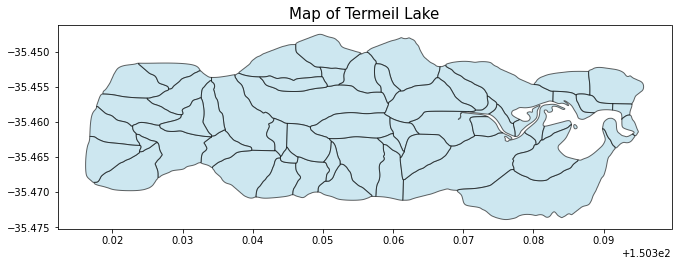

In [27]:
map_3()

In [28]:
shp_file_name = "TR_Shape_2_shp/TUROSS_RIVER_143_HR.shp"
zip_file_name = "TR_Shape_2_shp.zip"
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


In [29]:
Shape_2 = gpd.GeoDataFrame.from_file(shp_file_name)
Shape_2.set_crs(epsg=8021, inplace=True, allow_override=True) 
Shape_2.sample(1)

,OBJECTID,ZONEID,CATCHMENT,NthSth,LIKELIHOOD,CONSEQUENC,RISK,Shape_Leng,Shape_Le_1,Shape_Area,geometry
44,9113,TUROSS RIVER 45,TUROSS RIVER,143.0,4.0,4.0,16.0,72277.330582,0.7174,0.013819,"POLYGON ((149.88738 -36.30299, 149.88733 -36.3..."


In [30]:
def map_4():
    Shape_2.geometry.plot(color='lightblue', alpha=0.6, edgecolor='black')
    plt.title("Map of Tuross River", fontsize=15)

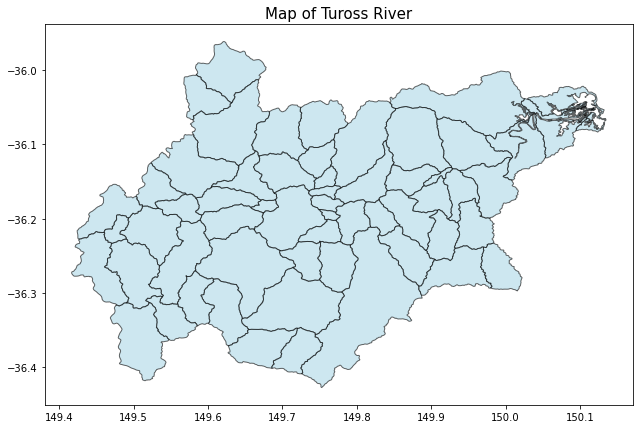

In [31]:
map_4()

# So how is the water quality being affected?

Below is a graph I created on the temperatures of the lakes during the bushfires. The average temperature of a standard lake in January/February is roughly around 21 degrees however, the temperatures in these lakes during the bushfires are shockingly high with Meroo Lake reaching 32.74 degrees on the 27th of January. 

In [32]:
def temp_lakes():
    for name, df in all_lakes_df.groupby("estuaryName"):
        df.set_index("dateTime").temp.plot(label=f"temp {name}")
    plt.legend()
    plt.xlim(["2020-01-21", "2020-02-17"])
    plt.title("Temperatures of lakes from January-February 2020")
    plt.show()
    print('Highest temperature - Meroo Lake:', (all_lakes_df['temp'].max()))

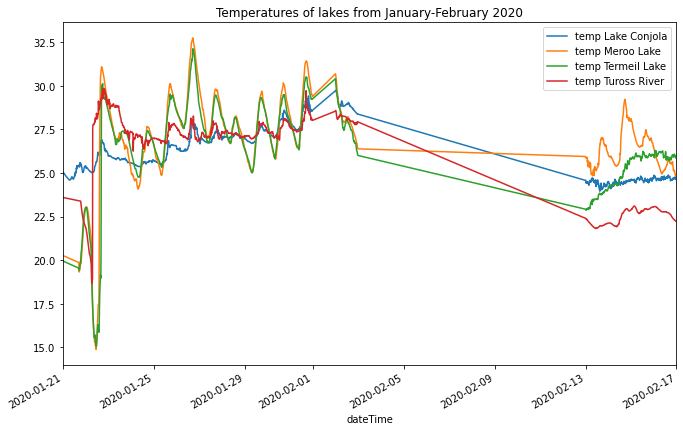

Highest temperature - Meroo Lake: 32.74


In [33]:
temp_lakes()

This graph displays the dissolved oxygen levels during the bushfires. There is a large drop when the bushfires occurred, and you can see the levels drop very low with Tuross River reaching levels below 0 at one stage. Healthy water should generally have dissolved oxygen concentrations above 6.5-8 mg/L. On the graph it shows that, below the point of 6-4 mg/L, very few fish can live and bwlow the point of 4-0 mg/L no fish can live.

In [34]:
def dissolvedOxygen_lakes():
    for name, df in all_lakes_df.groupby("estuaryName"):
        df.set_index("dateTime").dissolvedOxygen.plot(label=f"Dissolved oxygen {name}")
    plt.legend()
    plt.xlim(["2020-01-21", "2020-02-17"])
    plt.title("Dissolved Oxygen of lakes between January-February 2020", fontsize=15)
    plt.show()
    print('Lowest dissolved oxygen level - Tuross River:', (all_lakes_df['dissolvedOxygen'].min()))
    print('Healthy water should generally have dissolved oxygen concentrations above 6.5-8 mg/L')

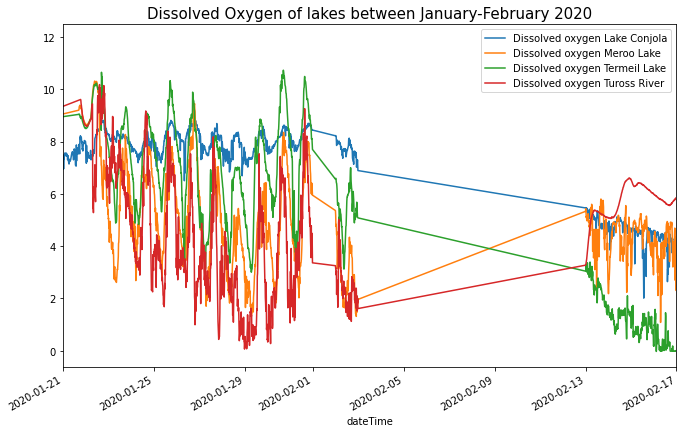

Lowest dissolved oxygen level - Tuross River: -0.03
Healthy water should generally have dissolved oxygen concentrations above 6.5-8 mg/L


In [35]:
dissolvedOxygen_lakes()

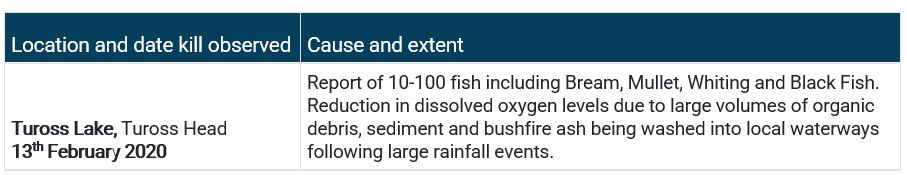

I researched about fish kills during the 2020 bushfires and found this result for Tuross River where a report of 10-100 dead fish were seen on the 13th of February 2020. There was definitely a significant death rate in fish and other aquatic species that lived in these lakes during the bushfires. 

In [36]:
def correlation():
    meroo_data = pd.read_csv("lake_data/Meroo_Lake_Bushfire_Water_Quality_Data.csv")
    meroo_data.columns = [
            "dateTime",
            "estuaryName",
            "siteID",
            "loggerID",
            "sampleDepth",
            "conductivity",
            "temp",
            "dissolvedOxygen",]
    dissolvedOxygen = meroo_data['dissolvedOxygen']
    temp = meroo_data['temp']

    plt.scatter(x=temp, y=dissolvedOxygen, cmap='blues', edgecolor='black', linewidth=1)
    plt.title('Correlation between temperature (C°) and dissolved oxygen (mg/L) in Lake Meroo', fontsize=15)
    plt.xlabel('Temperature (C°)', fontsize=12)
    plt.ylabel('Dissolved Oxygen (mg/L)', fontsize=12)
    plt.show()

I then created a scatter plot to see if there was a correlation between the temperature and dissolved oxygen. This is on Lake Meroo and you can see the dissolved oxygen levels decrease slowly as the temperature in the lake rises.

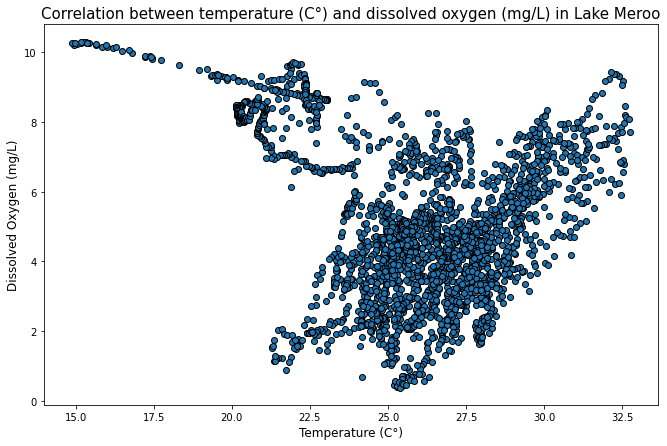

In [37]:
correlation()

# By 28 January 2020, the bushfires in NSW had burnt 5.3 million hectares (6.7% of the State)

In [38]:
shp_file_name = "BurntArea_2019-2020_shp/BurntArea.shp"
zip_file_name = "BurntArea_2019-2020_shp.zip"
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)

print("done")

BurntArea = gpd.GeoDataFrame.from_file(shp_file_name)
BurntArea.set_crs(epsg=8021, inplace=True, allow_override=True) 
BurntArea.sample(1)

loading from file
done


,OBJECTID,Id,Shape_Leng,Shape_Area,geometry
712,2628,1,0.0006,2.000000e-08,"POLYGON ((151.49397 -33.19031, 151.49387 -33.1..."


In [39]:
zip_file_name = "nsw_locality_polygon_shp.zip"
shp_file_name = "NSW_LOC_POLYGON_shp"
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()
 
map_file = unzip_zipfile(zip_file_name)
 
burbs = gpd.GeoDataFrame.from_file(shp_file_name)
burbs.set_crs(epsg=8021, inplace=True, allow_override=True) 
burbs.head(7)
 
cols_to_drop = ["NSW_LOCA_1", "NSW_LOCA_3", "NSW_LOCA_4","NSW_LOCA_5","NSW_LOCA_7", "DT_RETIRE"]
burbs.drop(cols_to_drop, axis=1, inplace=True, errors="ignore")
burbs.head(1)

,LC_PLY_PID,DT_CREATE,LOC_PID,NSW_LOCALI,NSW_LOCA_2,NSW_LOCA_6,geometry
0,34943,2021-02-09,NSW3128,2018-08-08,ORTON PARK,None,"POLYGON ((149.55618 -33.46707, 149.55619 -33.4..."


In [40]:
def map_AB():   
    fig, ax1 = plt.subplots()
    burbs.boundary.plot(ax=ax1, alpha=0.1, edgecolor='black') 

    BurntArea.plot(ax=ax1, color='red')

    plt.title("Map of Areas Burnt in NSW", fontsize=15)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.show()

I plotted on a map of NSW the areas that were burnt in red and you can see the how severly the South Coast was affected.

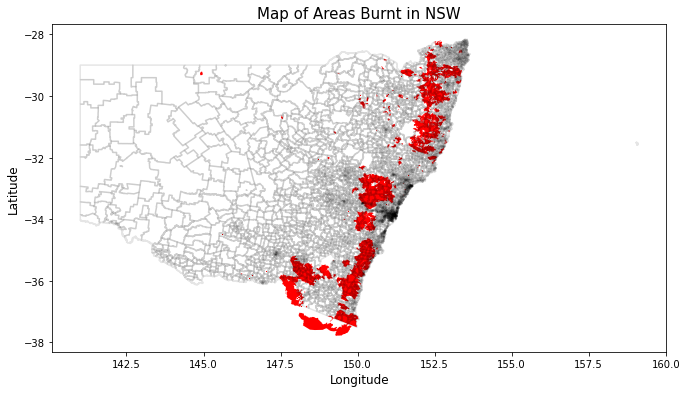

In [41]:
map_AB()

In [42]:
def areas_burnt():
    Catchments = ['Wonboyn River', 'Wapengo Lagoon', 'Tuross River', 'Tilba Tilba Lake', 
    'Termeil Lake', 'Smiths Lake', 'Khappinghat Creek', 'Myall Lake and River', 'Meroo Lake', 'Meringo Lagoon',
    'Durras Lake', 'Conjola Lake', 'Clyde River', 'Bellinger River', 'Bega River']
    Quantity = [92, 0, 79, 0, 66, 3, 81, 1, 57, 0, 69, 77, 93, 13, 16]
    
    plt.style.use('ggplot')
    
    plt.barh(Catchments,Quantity,color=(0.2, 0.4, 0.6, 0.6))
    plt.title('Areas burnt on lakes in NSW - February 2020', fontsize=15)
    plt.ylabel('Catchment', fontsize=12)
    plt.xlabel('Percentage of Area Burnt (%)', fontsize=12)
    plt.show()
    print('Areas burnt above 50% are marked as very high water quality impact risk')

This is a bar graph showing the percentage of areas burnt on lakes in NSW. You can see a lot of these lakes were affected and areas that were burnt above 50% were marked as very high water quality impact risk. 

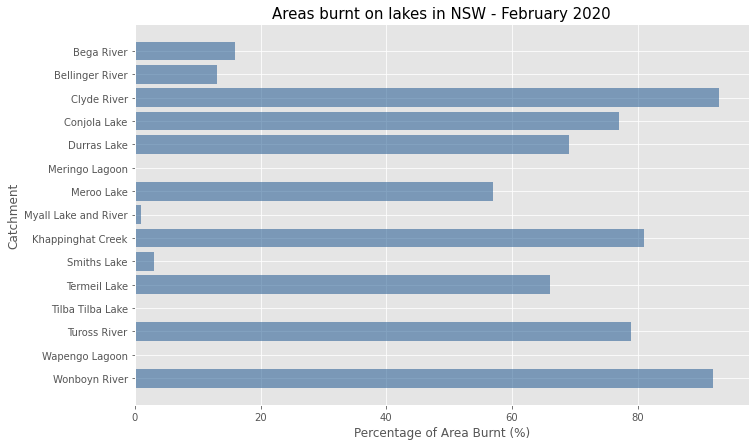

Areas burnt above 50% are marked as very high water quality impact risk


In [43]:
areas_burnt()

In [44]:
def areas_burnt2():
    Catchments = ['Tuross River','Termeil Lake','Meroo Lake', 'Conjola Lake']
    Quantity = [79, 66, 57, 77] 
    
    plt.style.use('ggplot')

    plt.barh(Catchments,Quantity,color=(0.2, 0.4, 0.6, 0.6))
    plt.title('Areas burnt on lakes in NSW - February 2020', fontsize=15)
    plt.ylabel('Catchment', fontsize=12)
    plt.xlabel('Percentage of Area Burnt (%)', fontsize=12)
    plt.show()
    print('Conjola Lake - 77%, Meroo Lake - 57%, Termeil Lake - 66%, Tuross River - 79%')

This is a close-up of the bar graph focusing just on the four lakes and you can see they are all above 50% of areas burnt.

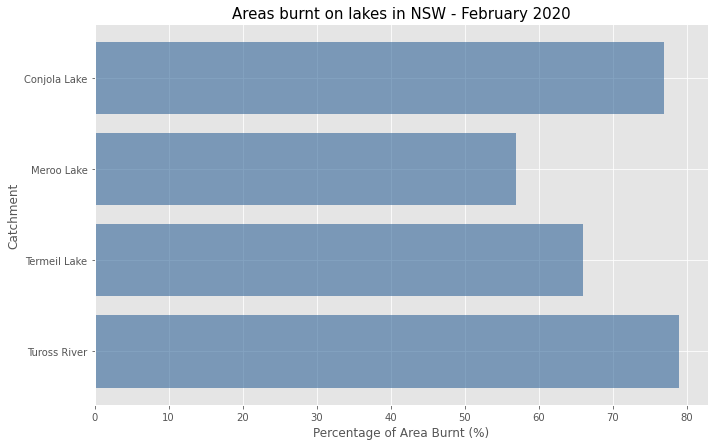

Conjola Lake - 77%, Meroo Lake - 57%, Termeil Lake - 66%, Tuross River - 79%


In [45]:
areas_burnt2()

In [46]:
def nutrients():
    labels = ['21/02/2002', '22/01/2020', '17/02/2020']
    Total_Nitrogen = [0.09, 0.628, 0.782]
    Total_Phosphorus = [0.24, 0.02, 0.005]

    x = np.arange(len(labels))  
    width = 0.1  

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, Total_Nitrogen, width, label='Total Nitrogen')
    rects2 = ax.bar(x + width/2, Total_Phosphorus, width, label='Total Phosphorus')

    ax.set_ylabel('mg/L', fontsize=12)
    ax.set_title('Nutrient Levels in Lake Conjola', fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()
    print('Normal Nitrogen and Phosphorus levels in 2002')

My last graph analyses the nitrogen and phosphorus levels in Lake Conjola. I was curious to see if there were drastic changes during the bushfires. I took data from February 2002 and compared it to January and February in 2020 when the bushfires occurred to see the difference. You can see the nitrogen and phosphorus levels are where they should be in 2002, but nitrogen drastically increased and phosphorus decreased in 2020. 

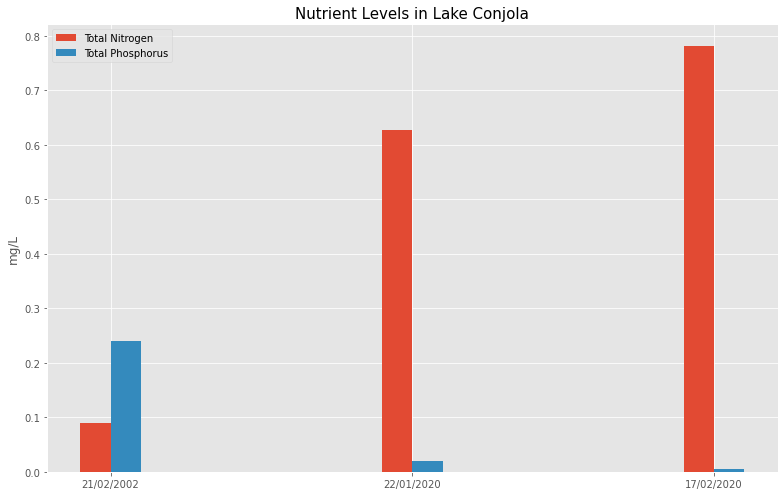

Normal Nitrogen and Phosphorus levels in 2002


In [47]:
nutrients()

These results from 2020 can have negative impacts on lakes. Excess nitrogen in lakes can cause overstimulation of growth of aquatic plants and algae. Excessive growth of these organisms can clog water intakes, use up dissolved oxygen and block light to deeper waters.

Phosphorus is an essential plant nutrient. When phosphorus levels are too high or too low, they can have harmful impacts on a lake's food web. This can then lead to degraded water quality and low oxygen which harm aquatic life.

# Conclusion
- Lakes can be severely impacted by bushfires and can be for years after the bushfires occur
- The immediate impacts include: drastic temperature increases, significant dissolved oxygen decreases, organic debris, sediment and bushfire ash being washed into the lakes, fish kills
- Some long-term impacts include: Limited shade over lakes due to burnt down trees and shrubs causing lakes to overheat, less insects which is a common food for many fish